# Imports

In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
import tensorflow as tf
from keras import layers, Model, Sequential, optimizers, losses, datasets, Input

# Params

In [50]:
LATENT_DIM = int(10e2)
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 2**10
EPOCHS = 100

# Generator

In [51]:
class Generator(Model):
    def __init__(self, latent_dim, image_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.image_shape = image_shape  # Сохраняем форму изображения

        # Вычисляем общий размер для выходного слоя
        self.output_size = np.prod(image_shape)

        # Определение слоев
        self.dense1 = layers.Dense(256)
        self.leaky_relu1 = layers.LeakyReLU(negative_slope=0.2)
        self.bn1 = layers.BatchNormalization(momentum=0.8)

        self.dense2 = layers.Dense(512)
        self.leaky_relu2 = layers.LeakyReLU(negative_slope=0.2)
        self.bn2 = layers.BatchNormalization(momentum=0.8)

        self.dense3 = layers.Dense(1024)
        self.leaky_relu3 = layers.LeakyReLU(negative_slope=0.2)
        self.bn3 = layers.BatchNormalization(momentum=0.8)

        # Выходной слой с динамическим размером
        self.output_layer = layers.Dense(self.output_size, activation="sigmoid")
        self.reshape = layers.Reshape(self.image_shape)

    def call(self, inputs, training=None):
        x = self.dense1(inputs)
        x = self.leaky_relu1(x)
        x = self.bn1(x, training=training)

        x = self.dense2(x)
        x = self.leaky_relu2(x)
        x = self.bn2(x, training=training)

        x = self.dense3(x)
        x = self.leaky_relu3(x)
        x = self.bn3(x, training=training)

        x = self.output_layer(x)
        return self.reshape(x)

    def build_model(self):
        x = Input(shape=(self.latent_dim,))
        return Model(inputs=[x], outputs=self.call(x))

In [52]:
generator = Generator(LATENT_DIM, IMG_SHAPE)
generator.build_model().summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,723,920 (6.58 MB)

 Trainable params: 1,720,336 (6.56 MB)

 Non-trainable params: 3,584 (14.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


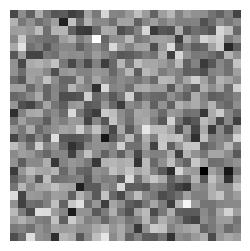

In [53]:
def generate_sample(generator, latent_dim, image_shape):
    noise = np.random.normal(0, 1, (1, latent_dim))
    generated_image = generator.predict(noise, verbose="auto")

    plt.figure(figsize=(3, 3))
    if image_shape[-1] == 1:  # Градации серого
        plt.imshow(generated_image[0, :, :, 0], cmap="gray")
    else:  # RGB или другие форматы
        plt.imshow((generated_image[0] * 255).astype(np.uint8))
    plt.axis("off")
    plt.show()


img = generate_sample(generator, LATENT_DIM, IMG_SHAPE)

# Discriminator

In [54]:
class Discriminator(Model):
    def __init__(self, img_shape):
        super().__init__()
        self.img_shape = img_shape
        
        self.flatten = layers.Flatten(input_shape=img_shape)
        self.dense1 = layers.Dense(512)
        self.leaky_relu1 = layers.LeakyReLU(0.2)
        self.dense2 = layers.Dense(256)
        self.leaky_relu2 = layers.LeakyReLU(0.2)
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.leaky_relu1(x)
        x = self.dense2(x)
        x = self.leaky_relu2(x)
        return self.output_layer(x)

    def build_model(self):
        # Метод для явной инициализации и проверки архитектуры
        x = Input(shape=self.img_shape)
        return Model(inputs=[x], outputs=self.call(x))

In [55]:
# Создание дискриминатора
discriminator = Discriminator(IMG_SHAPE)

# Инициализация весов (опционально, но рекомендуется)
discriminator.build_model().summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

# GAN

In [56]:
class GAN(Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # Генерация шума
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal([batch_size, LATENT_DIM])

        # Генерация фейковых изображений
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            # Предсказания для реальных и фейковых изображений
            real_pred = self.discriminator(real_images, training=True)
            fake_pred = self.discriminator(generated_images, training=True)

            # Вычисление потерь
            d_real_loss = self.loss_fn(tf.ones_like(real_pred), real_pred)
            d_fake_loss = self.loss_fn(tf.zeros_like(fake_pred), fake_pred)
            d_loss = (d_real_loss + d_fake_loss) * 0.5

            g_loss = self.loss_fn(tf.ones_like(fake_pred), fake_pred)

        # Обновление весов
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )
        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )

        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, self.generator.trainable_variables)
        )
        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables)
        )

        return {"d_loss": d_loss, "g_loss": g_loss}

    def predict(self, noise):
        # Генерация изображений по шуму
        return self.generator(noise, training=False)

# Train

In [57]:
def generate_images(model: Model, epoch: int | str, image_path: str = None, num_examples: int = 10):
    noise = tf.random.normal([num_examples, LATENT_DIM])
    generated = model.predict(noise)

    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(generated[i, :, :, 0], cmap="gray")
        plt.axis("off")
    if image_path is not None:
        plt.savefig(f"{image_path}/gan_generated_epoch_{epoch}.png")
    else:
        plt.savefig(f"gan_generated_epoch_{epoch}.png")
    plt.close()

In [58]:
def plot_images(model, num_examples: int = 10):
    noise = tf.random.normal([num_examples, LATENT_DIM])
    generated = model.predict(noise)

    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(generated[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.show()

In [59]:
generator = Generator(LATENT_DIM, IMG_SHAPE).build_model()
discriminator = Discriminator(IMG_SHAPE).build_model()

# Компиляция GAN
gan = GAN(generator, discriminator)
gan.compile(
    g_optimizer=optimizers.Adam(0.0002, 0.5),
    d_optimizer=optimizers.Adam(0.0002, 0.5),
    loss_fn=losses.BinaryCrossentropy(),
)

In [60]:
(x_train, _), (_, _) = datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 0.5) * 2
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000).batch(BATCH_SIZE)

In [61]:
x_train.shape

(60000, 28, 28, 1)

In [62]:
count_batches = len(dataset)
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    for index, batch in enumerate(dataset):
        print(f"batch {index + 1} out of {count_batches}")
        gan.train_step(batch)

    # Генерация примеров каждые 10 эпох
    # if (epoch + 1) % 10 == 0:
    generate_images(gan, epoch + 1, "images")
    print()

Epoch 1/100
batch 1 out of 59


d:\PyInterpreters\Big_data\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_133']
Received: inputs=Tensor(shape=(1024, 1000))
  warnings.warn(msg)
d:\PyInterpreters\Big_data\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_145']
Received: inputs=Tensor(shape=(1024, 28, 28, 1))
  warnings.warn(msg)


batch 2 out of 59
batch 3 out of 59
batch 4 out of 59
batch 5 out of 59
batch 6 out of 59
batch 7 out of 59
batch 8 out of 59
batch 9 out of 59
batch 10 out of 59
batch 11 out of 59
batch 12 out of 59
batch 13 out of 59
batch 14 out of 59
batch 15 out of 59
batch 16 out of 59
batch 17 out of 59
batch 18 out of 59
batch 19 out of 59
batch 20 out of 59
batch 21 out of 59
batch 22 out of 59
batch 23 out of 59
batch 24 out of 59
batch 25 out of 59
batch 26 out of 59
batch 27 out of 59
batch 28 out of 59
batch 29 out of 59
batch 30 out of 59
batch 31 out of 59
batch 32 out of 59
batch 33 out of 59
batch 34 out of 59
batch 35 out of 59
batch 36 out of 59
batch 37 out of 59
batch 38 out of 59
batch 39 out of 59
batch 40 out of 59
batch 41 out of 59
batch 42 out of 59
batch 43 out of 59
batch 44 out of 59
batch 45 out of 59
batch 46 out of 59
batch 47 out of 59
batch 48 out of 59
batch 49 out of 59
batch 50 out of 59
batch 51 out of 59
batch 52 out of 59
batch 53 out of 59
batch 54 out of 59
b

d:\PyInterpreters\Big_data\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_133']
Received: inputs=Tensor(shape=(608, 1000))
  warnings.warn(msg)
d:\PyInterpreters\Big_data\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_145']
Received: inputs=Tensor(shape=(608, 28, 28, 1))
  warnings.warn(msg)
d:\PyInterpreters\Big_data\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_133']
Received: inputs=Tensor(shape=(10, 1000))
  warnings.warn(msg)



Epoch 2/100
batch 1 out of 59
batch 2 out of 59
batch 3 out of 59
batch 4 out of 59
batch 5 out of 59
batch 6 out of 59
batch 7 out of 59
batch 8 out of 59
batch 9 out of 59
batch 10 out of 59
batch 11 out of 59
batch 12 out of 59
batch 13 out of 59
batch 14 out of 59
batch 15 out of 59
batch 16 out of 59
batch 17 out of 59
batch 18 out of 59
batch 19 out of 59
batch 20 out of 59
batch 21 out of 59
batch 22 out of 59
batch 23 out of 59
batch 24 out of 59
batch 25 out of 59
batch 26 out of 59
batch 27 out of 59
batch 28 out of 59
batch 29 out of 59
batch 30 out of 59
batch 31 out of 59
batch 32 out of 59
batch 33 out of 59
batch 34 out of 59
batch 35 out of 59
batch 36 out of 59
batch 37 out of 59
batch 38 out of 59
batch 39 out of 59
batch 40 out of 59
batch 41 out of 59
batch 42 out of 59
batch 43 out of 59
batch 44 out of 59
batch 45 out of 59
batch 46 out of 59
batch 47 out of 59
batch 48 out of 59
batch 49 out of 59
batch 50 out of 59
batch 51 out of 59
batch 52 out of 59
batch 53

In [63]:
generate_images(gan, "final")

d:\PyInterpreters\Big_data\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_133']
Received: inputs=Tensor(shape=(1, 1000))
  warnings.warn(msg)


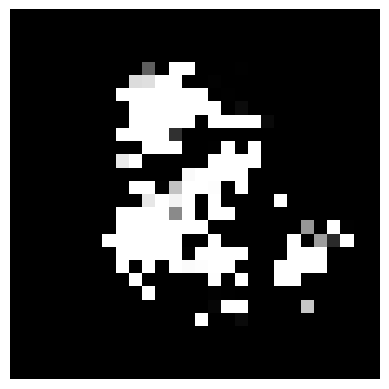

In [64]:
noise = tf.random.normal([1, LATENT_DIM])
generated_image = gan.predict(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()